# Reversing RRC Filtering
Given a set of samples filtered in QAM + RRC, take back the original data

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import commpy
from scipy import signal as scp_signal
import logging
import pickle

from timer.timer import Timer

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("QAM & RRC Defiltering")

In [3]:
timer = Timer()

### Read Signal source file and extract informations

In [4]:
def read_source() -> (float, list):
    logger.info("Reading signal source file")
    
    with open("out.txt", "rb") as f:
        data = pickle.load(f)

    sampling_rate = data["sampling_rate"]
    signal = np.array(data["data"], dtype=complex)
    return sampling_rate, signal
    
sampling_rate, signal = read_source()
logger.info(f"Sampling Rate: {sampling_rate}Hz")
logger.info(f"Signal Length: {signal.shape[0]}")

INFO:QAM & RRC Defiltering:Reading signal source file
INFO:QAM & RRC Defiltering:Sampling Rate: 1000000.0Hz
INFO:QAM & RRC Defiltering:Signal Length: 1000000


### Defilter the signal

In [5]:
# Filter Length, Roll off factor (alpha [0 1.0]), Symbol Period (s), Sampling rate (Hz)

def defilter(sampling_rate, signal, alpha=0.35, filter_length=704, destination="/tmp/sig_bits"):
    response = commpy.filters.rrcosfilter(filter_length, alpha, 1 / sampling_rate, sampling_rate)
    logger.info(f"Defiltering signal of length {signal.shape[0]}")
    sig_bits = np.convolve(response[1], signal)

    return sig_bits

sig_bits_destination = "/tmp/sig_bits"
sig_bits = defilter(sampling_rate, signal, destination=sig_bits_destination)
logger.info("Done")

INFO:QAM & RRC Defiltering:Defiltering signal of length 1000000
INFO:QAM & RRC Defiltering:Done


### Plot current signal (With RRC defiltering)

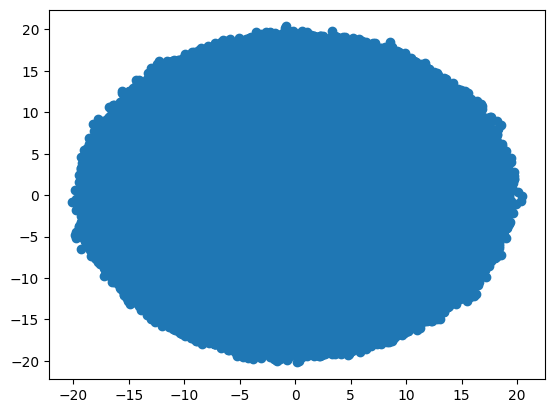

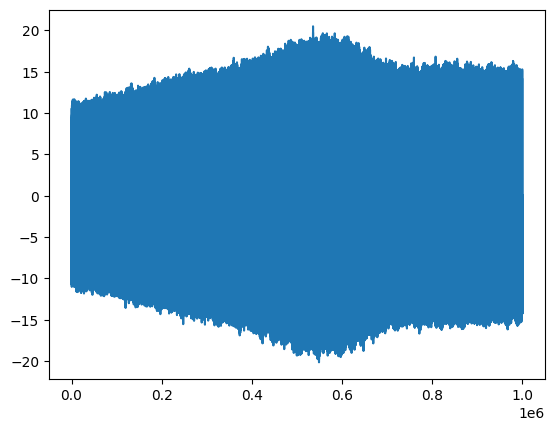

In [6]:
def plot_sig(signal: str):
    signal_index = len(signal) // 2
    plt.scatter(
        np.real(signal),
        np.imag(signal))
    plt.show()
    plt.plot(np.real(signal))
    plt.show()

plot_sig(sig_bits)

### That's missing Time & Frequency Synchronization

INFO:QAM & RRC Defiltering:Interpolating signal


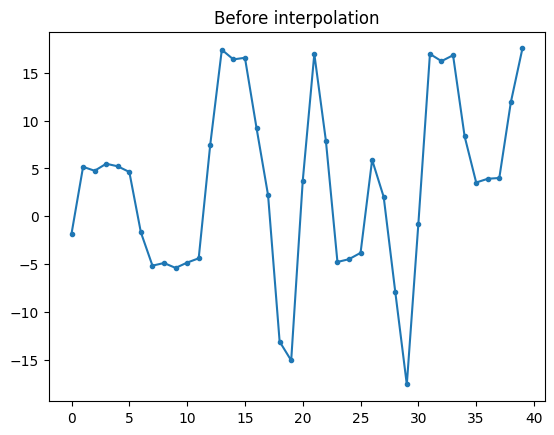

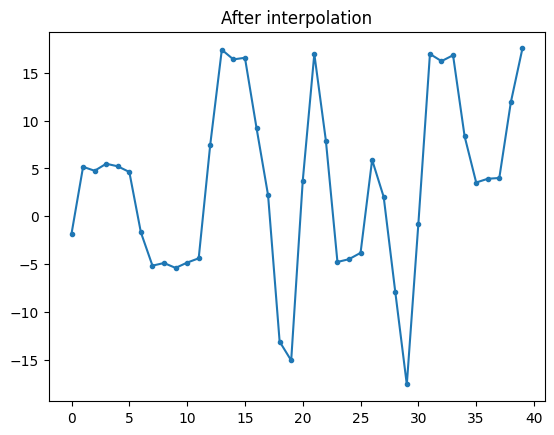

In [7]:
def interpolate_signal(sig_bits, interp_scale=1, samples_shown=100):
    logger.info("Interpolating signal")

    index = len(sig_bits) // 2
    plt.plot(
        np.real(
            sig_bits[len(sig_bits) // 2:len(sig_bits) // 2 + samples_shown]
        ),
        ".-"
    )
    plt.title("Before interpolation")
    plt.show()
    
    sig_bits = scp_signal.resample_poly(sig_bits, interp_scale, 1)

    plt.plot(
        np.real(
            sig_bits[len(sig_bits) // 2:len(sig_bits) // 2 + (samples_shown * interp_scale)]
        ),
        ".-"
    )
    plt.title("After interpolation")
    plt.show()
    
    return sig_bits

interpolated_signal = interpolate_signal(sig_bits, interp_scale=1, samples_shown=40)

In [8]:
# Clock recovery
@timer.time_this
def recover(signal, samples_per_symbols, feedback_rate=0.3, interp_scale=2):
    mu = 0
    out = np.zeros(len(signal) + 10, dtype=complex)
    out_rail = np.zeros(len(signal) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value
    i_in = 0  # Input sample index
    i_out = 2  # Output index (Let the first two be 0)
    while i_out < len(signal) and i_in + 16 < len(signal):
        out[i_out] = signal[i_in + int(mu)]  # Grab the "Best" sample
        out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
        x = (out_rail[i_out] - out_rail[i_out - 2]) * np.conj(out[i_out - 1])
        y = (out[i_out] - out[i_out - 2]) * np.conj(out_rail[i_out - 1])
        mm_val = np.real(y - x)
        mu += samples_per_symbols + feedback_rate * mm_val
        i_in += int(np.floor(mu))
        mu -= np.floor(mu)
        i_out += 1
    out = out[2:i_out]
    return out

# First step for frequency sync (has to happen before time sync)

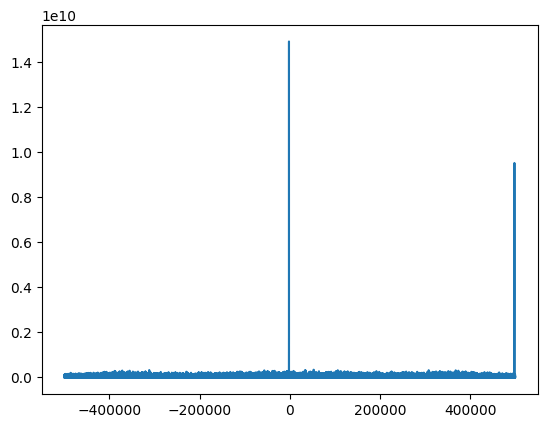

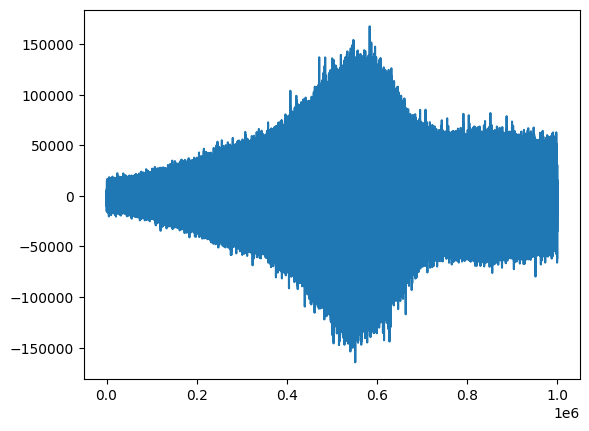

In [9]:
def square_samples(signal, sample_rate=1e6, modulation_scheme_order=4):  # QPSK by default
    signal = signal ** modulation_scheme_order
    psd = np.fft.fftshift(np.abs(np.fft.fft(signal)))
    f = np.linspace(-sample_rate/2.0, sample_rate/2.0, len(psd))
    plt.plot(f, psd)
    plt.show()
    
    max_freq = f[np.argmax(psd)]
    Ts = 1/sample_rate # calc sample period
    t = np.arange(0, Ts*len(signal), Ts) # create time vector
    signal = signal * np.exp(-1j*2*np.pi*max_freq*t/2.0)
    plt.plot(np.real(signal))
    plt.show()
    return signal

freq_coarse_sync_signal = square_samples(interpolated_signal, sample_rate=sampling_rate, modulation_scheme_order=4)

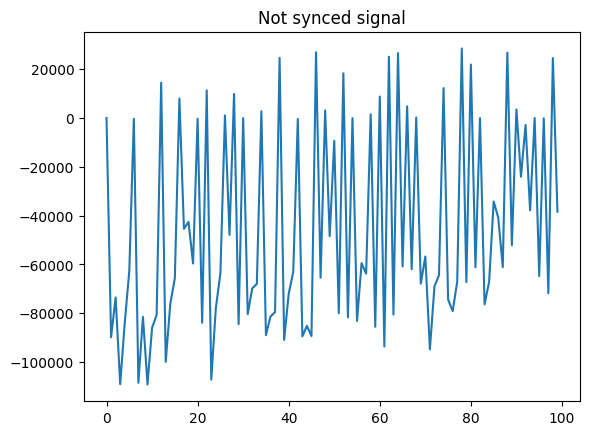

INFO:QAM & RRC Defiltering:Recovering clock
INFO:QAM & RRC Defiltering:Clock recovered in 0.08s


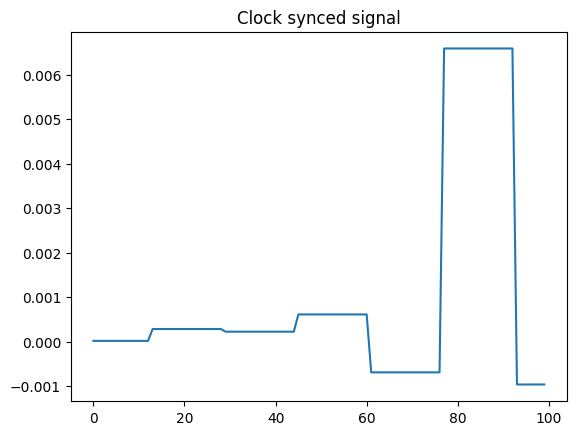

In [10]:
def recover_signal_clock(sig, interp_scale=1):
    recovered_interpolated_signal = []
    
    plt.plot(np.real(sig[len(sig) // 2:len(sig) // 2 + 100]))
    plt.title("Not synced signal")
    plt.show()

    logger.info("Recovering clock")
    sig = recover(sig, 1 / 16, interp_scale=interp_scale)
    logger.info(f"Clock recovered in {round(timer.get_time(), 2)}s")

    plt.plot(np.real(sig[len(sig) // 2:len(sig) // 2 + 100]))
    plt.title("Clock synced signal")
    plt.show()

    return sig

time_sync_signal = recover_signal_clock(freq_coarse_sync_signal, interp_scale=1)

### Let's see the QAM constellation now

(11462,)


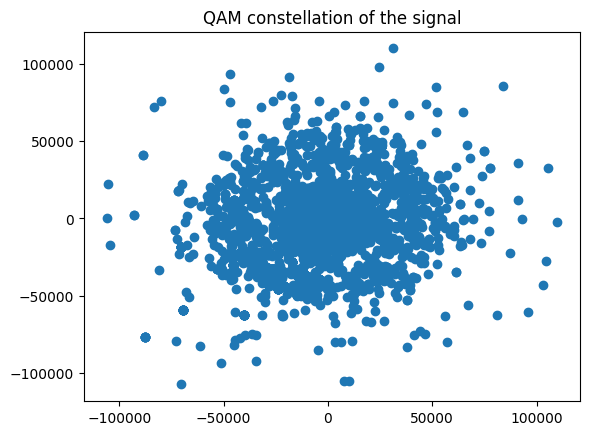

In [11]:
def show_qam_constellation(sig):
    print(sig.shape)
    signal_index = len(sig) // 2
    plt.scatter(np.real(sig), np.imag(sig))
    plt.title("QAM constellation of the signal")
    plt.show()

show_qam_constellation(time_sync_signal)

# Frequency Fine synchronization

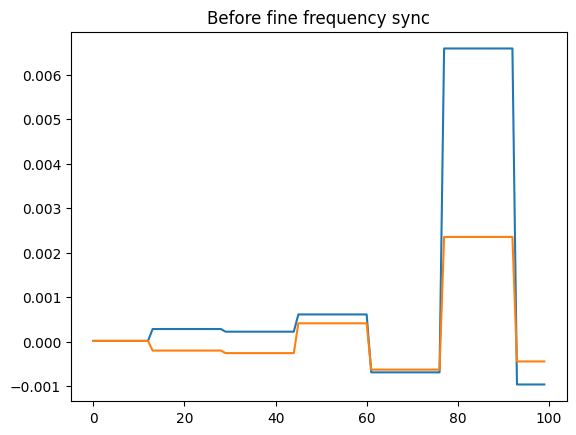

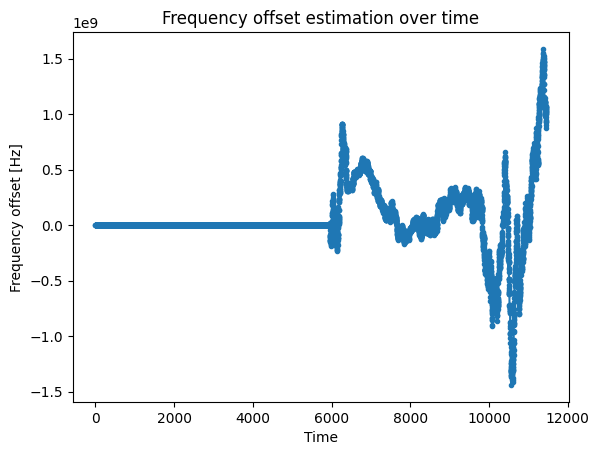

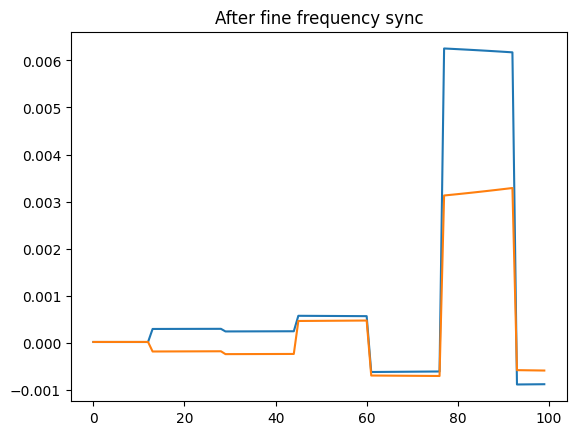

In [15]:
def error_equation_qpsk(sample):
    if sample.real > 0:
        a = 1.0
    else:
        a = -1.0
    if sample.imag > 0:
        b = 1.0
    else:
        b = -1.0
    return a * sample.imag - b * sample.real

def costas_loop(signal, sample_rate=1e6):
    N = len(signal)
    phase = 0
    freq = 0
    # These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
    alpha = 0.132
    beta = 0.00932
    out = np.zeros(N, dtype=complex)
    freq_log = []
    for i in range(N):
        out[i] = signal[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
        # error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)
        error = error_equation_qpsk(out[i]) # This is the error formula for 4th order Costas Loop (e.g. for QPSK)

        # Advance the loop (recalc phase and freq offset)
        freq += (beta * error)
        freq_log.append(freq * sample_rate / (2*np.pi)) # convert from angular velocity to Hz for logging
        phase += freq + (alpha * error)

        # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
        while phase >= 2*np.pi:
            phase -= 2*np.pi
        while phase < 0:
            phase += 2*np.pi

    # Plot freq over time to see how long it takes to hit the right offset
    plt.plot(freq_log, '.-')
    plt.title("Frequency offset estimation over time")
    plt.xlabel("Time")
    plt.ylabel("Frequency offset [Hz]")
    plt.show()
    return out

plt.plot(np.real(time_sync_signal[len(time_sync_signal) // 2:len(time_sync_signal) // 2 + 100]))
plt.plot(np.imag(time_sync_signal[len(time_sync_signal) // 2:len(time_sync_signal) // 2 + 100]))
plt.title("Before fine frequency sync")
plt.show()

freq_sync_signal = costas_loop(time_sync_signal, sample_rate=sampling_rate)

plt.plot(np.real(freq_sync_signal[len(freq_sync_signal) // 2:len(freq_sync_signal) // 2 + 100]))
plt.plot(np.imag(freq_sync_signal[len(freq_sync_signal) // 2:len(freq_sync_signal) // 2 + 100]))
plt.title("After fine frequency sync")
plt.show()

(11462,)


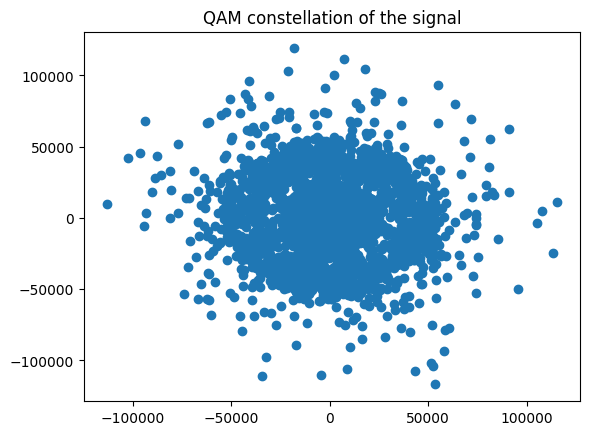

In [16]:
show_qam_constellation(freq_sync_signal)